# Sujet 1 : Concentration de CO2 dans l'atmosphère depuis 1958

En 1958, Charles David Keeling  a initié une mesure de la concentration de CO2 dans l'atmosphère à l'observatoire de Mauna Loa, Hawaii, États-Unis qui continue jusqu'à aujourd'hui. L'objectif initial était d'étudier la variation saisonnière, mais l'intérêt s'est déplacé plus tard vers l'étude de la tendance croissante dans le contexte du changement climatique. En honneur à Keeling, ce jeu de données est souvent appelé "Keeling Curve" (voir https://en.wikipedia.org/wiki/Keeling_Curve pour l'histoire et l'importance de ces données).

Les données sont disponibles sur le site Web de l'institut Scripps. Utilisez le fichier avec les observations hebdomadaires. Attention, ce fichier est mis à jour régulièrement avec de nouvelles observations. Notez donc bien la date du téléchargement, et gardez une copie locale de la version précise que vous analysez. Faites aussi attention aux données manquantes.

Votre mission si vous l'acceptez :
1. Réalisez un graphique qui vous montrera une oscillation périodique superposée à une évolution systématique plus lente.
2. Séparez ces deux phénomènes. Caractérisez l'oscillation périodique. Proposez un modèle simple de la contribution lente, estimez ses paramètres et tentez une extrapolation jusqu'à 2025 (dans le but de pouvoir valider le modèle par des observations futures).
3. Déposer dans FUN votre résultat

**Librairies**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Import des données

In [2]:
filename = 'weekly_in_situ_co2_mlo.csv'

if os.path.exists(filename):
    print('Using local file')
    data_path = filename
else:
    print('Downloading data from url')
    data_path = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv'

On importe les données en supprimant toutes les lignes de commentaires qui existent au début du fichier. La série de donnée commence la semaine du 29 Mars 1958. La 2ème colonne est renommée pour plus de lisibilité.

In [3]:
raw_data = pd.read_csv(data_path, skiprows=43, delimiter=',')
raw_data.columns = ['ppm']
raw_data.head()

ppm
1958-03-29  316.19
1958-04-05  317.31
1958-04-12  317.69
1958-04-19  317.58
1958-04-26  316.48

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3332 entries, 1958-03-29 to 2023-07-01
Data columns (total 1 columns):
ppm    3332 non-null float64
dtypes: float64(1)
memory usage: 52.1+ KB


On vérifie si des données sont mal renseignées : Non

In [5]:
print(raw_data['ppm'].isna().any())
raw_data[raw_data.isnull().any(axis=1)]

False


Empty DataFrame
Columns: [ppm]
Index: []

In [6]:
data = raw_data.copy().reset_index()
data.head()

index     ppm
0  1958-03-29  316.19
1  1958-04-05  317.31
2  1958-04-12  317.69
3  1958-04-19  317.58
4  1958-04-26  316.48

On vérifie si toutes les semaines sont présentes dans les données : ce n'est pas le cas pour les années ci-dessous. Deux cas de figure se présentent :
- pour l'année 1958 (première date de la série) et l'année 2023 (dernière date de la série) $\rightarrow$ pas de problème
- pour les autres années $\rightarrow$ quelques semaines sont manquantes, on décide de continuer l'analyse tel quel mais on garde l'information en tête

In [7]:
# calcul du nombre de semaines présentes par année
data['year'] = data['index'].apply(lambda x: x[:4])
years = data.groupby(['year'])['year'].count().index
nb_weeks = data.groupby(['year'])['year'].count().values
for x, y in zip(years, nb_weeks):
    if y < 50:
        print(x, y)

1958 25
1959 48
1962 48
1963 49
1964 31
1966 49
1984 48
2003 49
2005 49
2023 26


## Affichage des données à décomposer

In [8]:
data = data.set_index('index')

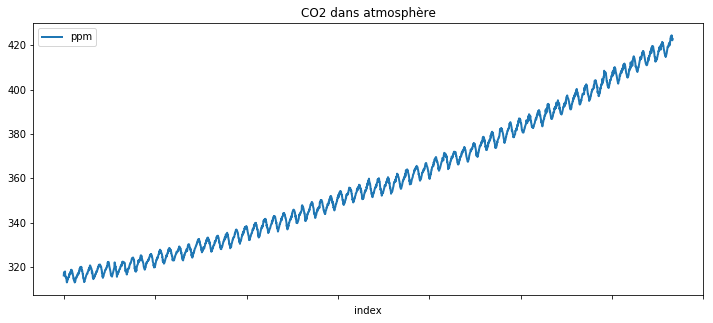

In [9]:
data.plot(y='ppm', kind='line',figsize=(12, 5), lw=2, title="CO2 dans atmosphère");

On observe bien une oscillation périodique ainsi qu'une tendance à la hausse plus lente.

### Decomposition des séries

In [10]:
y = data.reset_index()['ppm'].values
x = data.reset_index()['index'].values

In [11]:
res = seasonal_decompose(y, model='additive', freq=52)

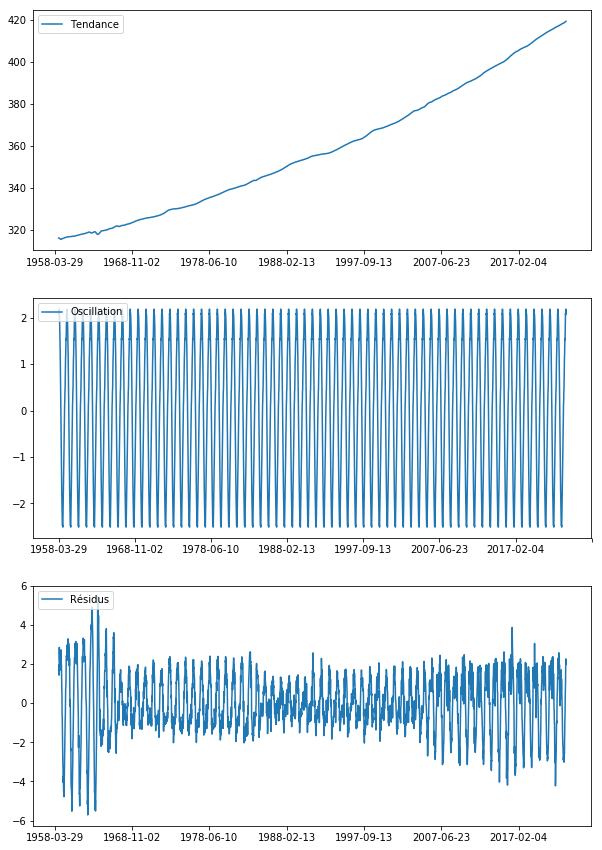

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
axes[0].plot(res.trend, label='Tendance')
axes[1].plot(res.seasonal, label='Oscillation')
axes[2].plot(res.resid, label='Résidus')
for i in range(3):
    axes[i].set_xticklabels(x[[j for j in range(-500, 3500, 500)]])
    axes[i].legend(loc='upper left');

### Apprentissage d'un modèle simple sur la tendance lente et prédictions

On cherche à apprendre un modèle linéaire sur la tendance lente.

In [13]:
X = np.arange(0, len(x)).reshape(-1, 1)

# Model
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
# Score du modèle sur les données d'entrâinement
r2_score(y, model.predict(X))

0.976691466648821

In [15]:
# Nombre de semaines restant jusque 2025
def count_weeks_until_year(start_date, target_year):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    target_date = datetime(target_year, 1, 1)
    delta = target_date - start_date
    weeks = delta.days // 7
    return weeks

start_date_str = x[-1]
target_year = 2025

weeks_until_target_year = count_weeks_until_year(start_date_str, target_year)
weeks_until_target_year

78

In [16]:
# Prédictions
weeks_untils_2025 = np.arange(int(X[[-1]]) + 1, int(X[[-1]]) + 1 + weeks_until_target_year)
preds = model.predict(weeks_untils_2025.reshape(-1, 1))

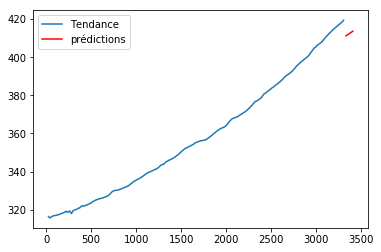

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(res.trend, label='Tendance')
ax.plot(weeks_untils_2025, preds, color='r', label='prédictions')
plt.legend();

Ce modèle n'est pas particulièrement adapté, il sous-estime très nettement la quantité de $CO_2$.

### Utlisation des lags comme attributs du modèle. 

On complexifie légèrement le modèle afin d'utiliser des attributs correspondants aux "lags" des valeurs de $CO2$ dans celui-ci.

In [18]:
data['ppm_lag1'] = data['ppm'].shift(1)
data['ppm_lag2'] = data['ppm'].shift(2)

In [19]:
data.head()

ppm  year  ppm_lag1  ppm_lag2
index                                       
1958-03-29  316.19  1958       NaN       NaN
1958-04-05  317.31  1958    316.19       NaN
1958-04-12  317.69  1958    317.31    316.19
1958-04-19  317.58  1958    317.69    317.31
1958-04-26  316.48  1958    317.58    317.69

In [20]:
# Suppression des lignes contenant des NaN dues au décalage
data = data.dropna()

In [21]:
X = data[['ppm_lag1', 'ppm_lag2']]
y = data['ppm']

In [22]:
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

On utilise les 2 dernières semaines disponibles dans les données pour prédire la semaine à venir, et ainsi de suite (en utilisation les prédictions au fur et à mesure) jusqu'à 2025.

In [23]:
ppm = list(data['ppm'].values)
ppm_preds = []

for i in range(weeks_until_target_year):
    new_data = {
        'ppm_lag1': [ppm[-1]],
        'ppm_lag2': [ppm[-2]]
    }
    pred = model.predict(pd.DataFrame(new_data))
    ppm.append(pred)
    ppm_preds.append(float(pred))

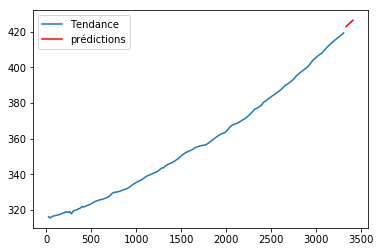

In [24]:
fig, ax = plt.subplots(1, 1)
ax.plot(res.trend, label='Tendance')
ax.plot(weeks_untils_2025, ppm_preds, color='r', label='prédictions')
plt.legend();

Ce modèle semble plus cohérent que le précédent.